In [2]:
import os
import sys

import pandas as pd
import glob
import pickle
import json
import re

import time
from tqdm import tqdm, trange

import seaborn as sns
import matplotlib
from matplotlib import pyplot
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from textwrap import wrap

import numpy as np
import scipy
import sklearn

sys.path.append( os.path.abspath(os.path.join('..')) )
from helper.visualization import plot_Q

data_directory = '/Users/lamk5/Desktop/Data/CBCL-Analysis/'
# output_directory = os.path.join(os.path.realpath('..'), 'output/')
output_directory = '../output'


### Visualization functions

In [89]:
def plot_QuestionNan(data_df, columns, question, threshold, dataname):
    
    M = data_df[columns].values.astype('float')
    
    missing_ratio = np.sum(np.isnan(M), axis=0) / M.shape[0]
    if np.sum( missing_ratio > threshold) > 0:
        fig, ax = pyplot.subplots(figsize=(16,2))
        rects = ax.bar(np.linspace(0, M.shape[1]-1, M.shape[1]), missing_ratio)
        question_index = []
        question_show = []
        for (i,rect) in enumerate(rects):
            height = rect.get_height()
            if height > 0.05:
                question_index.append(i)
                question_show.append(question[i])
                ax.annotate('{:.2f} %'.format(height*100),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        ax.set_title('Questions with > 5 % missing entries in {} dataset'.format(dataname))
        ax.set_xticks(question_index)
        ax.set_xticklabels(question_show, rotation=90)
        ax.set_ylim([0,1])
        pyplot.show()
    else:
        print('No question is needed to elimiated.')
        
    print('{} entries are NaN before dropping questions.'.format(np.sum(np.isnan(M))))



In [90]:
def plot_ScoreDistribution(data_df, columns, question, dataname):
    
    
    M = data_df[columns].values.astype('float')
    
    fig, ax = pyplot.subplots(figsize=(16,6))
    count1 = []
    count2 = []
    for k in range(M.shape[1]):
        count1.append((np.where(M[:,k] == 1)[0].shape[0]))
        count2.append((np.where(M[:,k] == 2)[0].shape[0]))

    ax.bar(np.linspace(1,M.shape[1],M.shape[1]),
           np.asarray(count1)+np.asarray(count2),label='1 (somewhat or sometimes true)')
    ax.bar(np.linspace(1,M.shape[1],M.shape[1]),count2, label='2 (very or often true)')
    ax.set_xticks(np.linspace(1,M.shape[1],M.shape[1]))
    ax.set_xticklabels(question, fontsize=9, rotation=90)
    ax.set_title('CBCL scores for {} dataset'.format(dataname), fontsize=20)
    ax.legend(fontsize=14)
    pyplot.tight_layout()
    pyplot.show()
    
    
    fig, ax = pyplot.subplots(figsize=(16,5))
    colors = ['w','b','r']
    nbins = 3
    cm = matplotlib.colors.LinearSegmentedColormap.from_list('triple_cmap', colors, N=nbins)
    ax.matshow(M.T, aspect='auto', cmap=cm, alpha=0.7)
    ax.set_ylabel('Questions', fontsize=14)
    ax.set_xlabel('Subjects', fontsize=14)
    pyplot.show

### Load CBCL questions information (2001 version)
- The questions are the 2001 version (which is the same as ABCD and HBN)
- Introduce a new column to encode questions' group ID. For instance, 4-002 stands for Question Group 4, second question.

In [7]:
CBCL_question = pd.read_csv(os.path.join(data_directory,'NIH-CBCL/CBCL2001_item_variables2.csv'), index_col=False)
CBCL_question
CBCL_question = CBCL_question.iloc[:-1,:]
QuestionClass = list(np.unique(CBCL_question['CBCL2001_6-18_scale'].values))
group_index = []
CBCL_question
for k in range(CBCL_question.shape[0]):
    qid = CBCL_question.loc[k]['CBCL2001_6-18_varname'].split('.')[0]
    group_index.append(str(QuestionClass.index(CBCL_question.loc[k]['CBCL2001_6-18_scale'])) + '-' + qid)
CBCL_question['group'] = group_index
CBCL_question

CBCL_question.to_csv(os.path.join(output_directory, 'preprocessed/CBCL_variables.csv') , index=False)


In [8]:
question = CBCL_question['CBCL2001_6-18_varname'].values

### HBN CBCL
- in `cbcl_for_dx.csv` we have 1179 subjects, which are subjects having both CBCL data and diagnostic information
- in `HBN_participantDx.csv` we have 1335 patients, in which the subjects may not have diagnostic information
- in `9994_CBCL_20200721.csv`, we have 2111 subjects, which are subjects having CBCL data
- in participant.txt, the eid are subjects which have imaging data

We will use the intersection of `9994_CBCL_20200721.csv` and `participant.txt` to build factor model, which contains 1492 subjects.

The corresponding EID is stored in `eid_CBCL_Imaging_20210519.csv`

In [26]:
HBN_CBCL = pd.read_csv( os.path.join(data_directory, "HBN-CBCL/9994_CBCL_20200721.csv"), index_col=0, low_memory=False)
HBN_CBCL = HBN_CBCL.iloc[1:,:]

,Subject Type,Visit,Days since enrollment,EID,Start_Date,Study,Site,Days_Baseline,Year,Season,...,CBCL_AB,CBCL_AB_T,CBCL_OP,CBCL_Int,CBCL_Int_T,CBCL_Ext,CBCL_Ext_T,CBCL_C,CBCL_Total,CBCL_TOTAL_T
Anonymized ID,,,,,,,,,,,,,,,,,,,,,
A00078864,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,14,68,3,12,62,18,67,28,58,68
A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,20,76,8,19,69,25,73,33,77,72
A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,33,2015,Summer,...,19,73,10,32,78,26,72,40,98,76
A00078867,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,16,69,9,39,80,19,66,42,100,75
A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,7,57,6,9,58,11,57,32,52,64


In [27]:
HBN_CBCL_Demos = pd.read_csv( os.path.join(data_directory, "HBN-CBCL/9994_Basic_Demos_20200721.csv"), index_col=0, low_memory=False)
HBN_CBCL_Demos = HBN_CBCL_Demos.iloc[1:,:]

,Subject Type,Visit,Days since enrollment,EID,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
Anonymized ID,,,,,,,,,,,,,,
A00078864,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,NDARYM832PX3,2015,Spring,1,7.048254,1,No,1,Complete
A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,NDARNJ687DMC,2015,Spring,1,6.348163,1,No,1,Complete
A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,NDARRM363BXZ,2015,Spring,0,10.052589,1,No,1,Dropout
A00078867,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,NDARUW586LLL,2015,Spring,1,12.319415,1,No,1,Complete
A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,NDARDC298NW4,2015,Spring,0,13.901437,1,No,1,Complete


In [31]:
HBN = HBN_CBCL.merge(HBN_CBCL_Demos, on=['EID', 'Subject Type', 'Visit', 'Days since enrollment' ])
HBN.head()

,Subject Type,Visit,Days since enrollment,EID,Start_Date,Study,Site,Days_Baseline,Year,Season,...,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
0,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,1901-01-01T07:00:00Z,NDARYM832PX3,2015,Spring,1,7.048254,1,No,1,Complete
1,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,1901-01-01T07:00:00Z,NDARNJ687DMC,2015,Spring,1,6.348163,1,No,1,Complete
2,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,33,2015,Summer,...,1901-01-01T07:00:00Z,NDARRM363BXZ,2015,Spring,0,10.052589,1,No,1,Dropout
3,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,1901-01-01T07:00:00Z,NDARUW586LLL,2015,Spring,1,12.319415,1,No,1,Complete
4,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,1901-01-01T07:00:00Z,NDARDC298NW4,2015,Spring,0,13.901437,1,No,1,Complete


In [36]:
HBN['Age'] = HBN['Age'].values.astype('float')
HBN_originalsize = HBN.shape[0]
HBN_subjNAN_count = 0
HBN_ageNaN = np.where(np.isnan(HBN['Age']))[0]
if HBN_ageNaN.shape[0] > 0:
    HBN_subjNAN_count += HBN_ageNaN.shape[0]
    
print('Number of subjects missing Age information: {}'.format(HBN_subjNAN_count))
#     HBN_CBCL = HBN_CBCL.drop(HBN_ageNaN).reset_index(drop=True)

Number of subjects missing Age information: 0


In [40]:
HBN['Sex'] = HBN['Sex'].values.astype('float')
HBN_originalsize = HBN.shape[0]
HBN_subjNAN_count = 0
HBN_ageNaN = np.where(np.isnan(HBN['Sex']))[0]
if HBN_ageNaN.shape[0] > 0:
    HBN_subjNAN_count += HBN_ageNaN.shape[0]
    
print('Number of subjects missing Sex information: {}'.format(HBN_subjNAN_count))
#     HBN_CBCL = HBN_CBCL.drop(HBN_ageNaN).reset_index(drop=True)

Number of subjects missing Sex information: 0


In [80]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

CBCL_column = [c for c in HBN.columns.tolist() if ('CBCL_' in c) & hasNumbers(c) & ('113' not in c)]
CBCL_subscale_raw = [c for c in HBN.columns.tolist() if ('CBCL_' in c) & ~hasNumbers(c) & (c[-2:] != ('_T'))]
CBCL_subscale_T = [c for c in HBN.columns.tolist() if ('CBCL_' in c) & ~hasNumbers(c) & (c[-2:] == ('_T'))]

In [81]:
CBCL_subscale_T

['CBCL_AD_T',
 'CBCL_WD_T',
 'CBCL_SC_T',
 'CBCL_SP_T',
 'CBCL_TP_T',
 'CBCL_AP_T',
 'CBCL_RBB_T',
 'CBCL_AB_T',
 'CBCL_Int_T',
 'CBCL_Ext_T',
 'CBCL_TOTAL_T']

In [84]:
assert(len(CBCL_column) == question.shape[0])

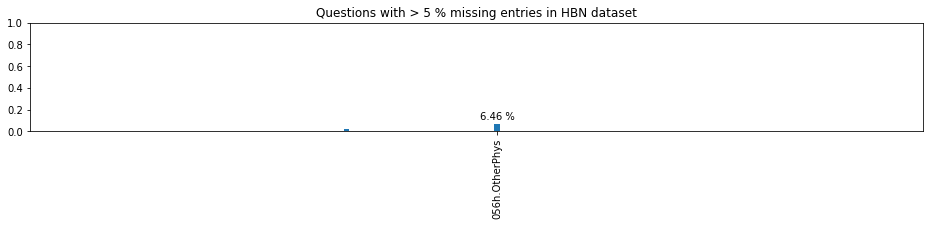

697 entries are NaN before dropping questions.


In [88]:
plot_QuestionNan(HBN, CBCL_column, question, 0.05, 'HBN')

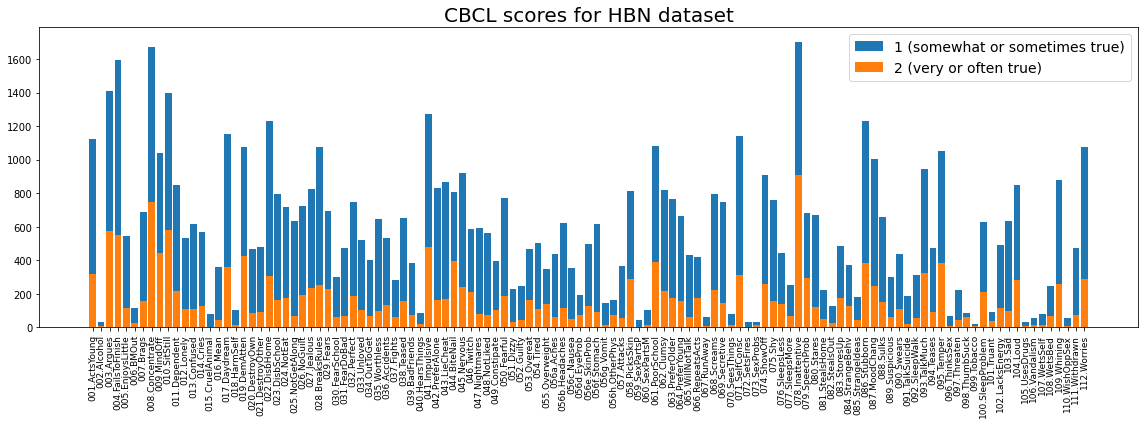

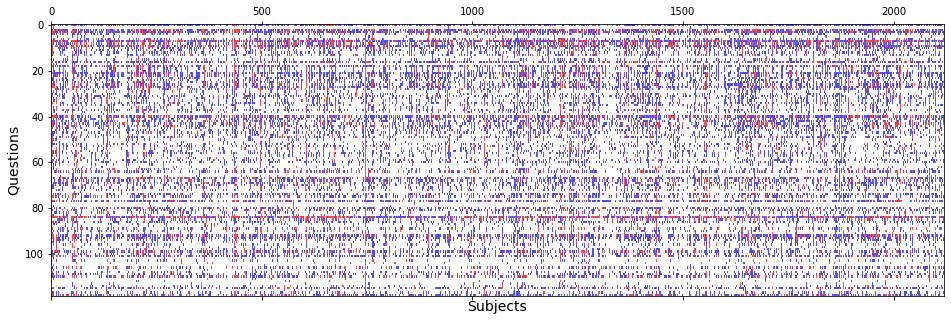

In [94]:
plot_ScoreDistribution(HBN, CBCL_column, question, 'HBN')

In [95]:
HBN_image = pd.read_csv( os.path.join(data_directory, 'HBN-CBCL/participants.txt'), low_memory=False, header=None, names=['eid'])

In [96]:
HBN_image

,eid
0,NDARAA075AMK
1,NDARAA536PTU
2,NDARAA947ZG5
3,NDARAA948VFH
4,NDARAB055BPR
...,...
2070,NDARZW930MF2
2071,NDARZX163EWC
2072,NDARZY101JNB
2073,NDARZY668NMV


In [97]:
HBN_participant = HBN[HBN['EID'].isin(HBN_image['eid'])]

In [98]:
HBN_participant

,Subject Type,Visit,Days since enrollment,EID,Start_Date,Study,Site,Days_Baseline,Year,Season,...,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
0,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,1901-01-01T07:00:00Z,NDARYM832PX3,2015,Spring,1.0,7.048254,1,No,1,Complete
1,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,1901-01-01T07:00:00Z,NDARNJ687DMC,2015,Spring,1.0,6.348163,1,No,1,Complete
7,UNKNOWN,V1,0,NDARED632KNG,1901-01-01T07:00:00Z,HBN,1,0,2015,Spring,...,1901-01-01T07:00:00Z,NDARED632KNG,2015,Spring,1.0,17.203855,1,No,1,Complete
11,UNKNOWN,V1,0,NDARFM080VAF,1901-01-01T07:00:00Z,HBN,1,2,2015,Summer,...,1901-01-01T07:00:00Z,NDARFM080VAF,2015,Summer,1.0,7.623203,1,No,1,Complete
13,UNKNOWN,V1,0,NDARFW130NGG,1901-01-01T07:00:00Z,HBN,1,39,2015,Summer,...,1901-01-01T07:00:00Z,NDARFW130NGG,2015,Summer,1.0,8.316107,1,No,1,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,UNKNOWN,V1,0,NDARRZ356HET,1901-01-01T07:00:00Z,HBN,3,22,2019,Winter,...,1901-01-01T07:00:00Z,NDARRZ356HET,2019,Winter,0.0,9.515742,3,Yes,7,Complete
2113,UNKNOWN,V1,0,NDARMN415AXR,1901-01-01T07:00:00Z,HBN,3,42,2019,Spring,...,1901-01-01T07:00:00Z,NDARMN415AXR,2019,Winter,0.0,7.798539,3,Yes,7,Complete
2115,UNKNOWN,V1,0,NDARKZ198TAA,1901-01-01T07:00:00Z,HBN,3,19,2019,Winter,...,1901-01-01T07:00:00Z,NDARKZ198TAA,2019,Winter,0.0,7.313940,3,Yes,7,Complete
2117,UNKNOWN,V1,0,NDAREW074ZM2,1901-01-01T07:00:00Z,HBN,1,8,2019,Spring,...,1901-01-01T07:00:00Z,NDAREW074ZM2,2019,Winter,0.0,6.777207,1,Yes,7,Complete


In [99]:
HBN_participant.to_csv( os.path.join(output_directory, 'preprocessed/HBN_participants_20210519.csv'), index=False)